# Feature Engineering and Selection

Feature engineering is the process of selecting, manipulating and transforming raw data into features that can be used in supervised learning. It leverages the existing data to create new variables that do not exist in the original dataset. In regards to an EDA, the overall goal is to find patterns in data. This process comes after one goes thorugh the process of Understanding the data, handles the missing data and preprocesses it (topics covered in the notebook [Data Cleaning and Preprocess](DataCleaning_Preprocessing.ipynb)).

In this notebook, some techniques will be showcased, namely: Feature Creation, Multicollinearity Detection, Feature Selection techniques and Dimensionality Reduction, which was already skimmed in previous repositories.

## Index



**Libraries and Datasets to use:**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_regression, RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_titanic = sns.load_dataset("titanic")  # Categorical-heavy dataset
df_diamonds = sns.load_dataset("diamonds")  # Numerical-heavy dataset

df_diamonds.head()



,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## 1. Feature Creation

Feature creation involves transforming raw data into features that better represent the underlying problem to predictive models, resulting in improved model accuracy on unseen data. We can divide this process in some groups:

- **Interaction feature creation:** We can do some polynomial transformations on existing features, creating new ones (`Polynomial Features`), or we can combine features to capture interactions between them (`Interaction Terms`);
- **Binning and Discretization:** Basing on continuous variables, we can, respectively, convert them into discrete bins (`Binning`) or transform them into categorical variables (`Discretization`);
- **Time-Based features:** When dealing with these kinds of features, we can extract time components such as day, month, year, etc. or also calculate elapsed times, IE time deltas ($\Delta  t$);
- **Text Data:** From text data, we can: 
  - split it into individual words or tokens (`Tokenization`); 
  - transform it into numerical vectors based on Term Frequency-Inverse Document Frequency (`TF-IDF`);
  - represent words in a continuous vector space, using pre-trained models like Word2Vec or GloVe (`Word Embeddings`)

We can see below an example of the Ineraction feature creation technique to generate new features on the **diamonds** example dataset ($a^2, a*b$ and $b^2$):

In [11]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
diamond_features = df_diamonds[['carat', 'depth']]
diamond_poly = poly.fit_transform(diamond_features)
print("Original Features:", diamond_features.head())
print("Polynomial Features:", diamond_poly[:5, 2:])

Original Features:    carat  depth
0   0.23   61.5
1   0.21   59.8
2   0.23   56.9
3   0.29   62.4
4   0.31   63.3
Polynomial Features: [[5.29000e-02 1.41450e+01 3.78225e+03]
 [4.41000e-02 1.25580e+01 3.57604e+03]
 [5.29000e-02 1.30870e+01 3.23761e+03]
 [8.41000e-02 1.80960e+01 3.89376e+03]
 [9.61000e-02 1.96230e+01 4.00689e+03]]


## 2. Multicollinearity Detection

Multicollinearity is a statistical phenomenon in which two or more predictor variables in a multiple regression model are highly correlated, meaning that one can be linearly predicted from the others with a substantial degree of accuracy. This can cause problems in regression analysis because it undermines the statistical significance of independent variables.

To uncover multicollinearity, we follow some steps:

1. **Examine correlation matrix:** After computing the correlation matrix, we want to look for pairs of features whose correlation coefficients are relatively high (should examine further if said values are placed around 0.7 or higher);
2. **Calculate Variance Inflation Factor (VIF):**  VIF measures how much the variance of an estimated regression coefficient increases if your predictors are correlated. If no factors are correlated, the VIFs will all be 1. We want to look for features whose VIF score is high (usually either >=5 or >=10);
3. **Check Tolerance:** Tolerance is the reciprocal of VIF. It measures the amount of variability of the selected independent variable not explained by the other independent variables. We want to flag scores close to 0;
4. **Analyze Eigenvalues and Condition Index:** Eigenvalues and condition indices are derived from the correlation matrix of the predictors. Eigenvalues close to 0 are to be looked for and Condition Indexes greater than 15 indicate potential multicollinearity problem, while values greater than 30 suggests serious multicollinearity.
5. **Visual Inspection:** We can use scatterplots and partial regression plots to visually inspect relationships between predictors.

If multicollinearity is detected, we usually aply a PCA to solve the issue, by transforming the original correlated variables into a set of uncorrelated variables (the `principal components`).

**WARNING:** A target feature should not in any way be subject to this kind of analysis. It can lead to wrong conclusions and the PCA effectively destroys the interpretability of the data and subsequently the model. In the cell below we include the `price` feature (a potential target), because we know it is highly correlated with the `carat` feature.

Below we can find a quick example of this exercise:

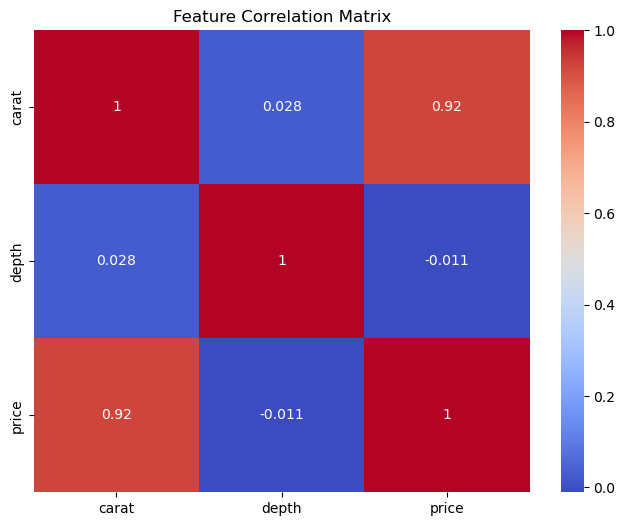

VIF Data:
  Feature       VIF
0   carat  6.701402
1   depth  1.009811
2   price  6.696823

Tolerance Data:
  Feature       VIF  Tolerance
0   carat  6.701402   0.149223
1   depth  1.009811   0.990284
2   price  6.696823   0.149325

Eigenvalues:
[0.07758957 1.92175896 1.00065147]

Condition Index:
[4.97677249 1.         1.38582387]


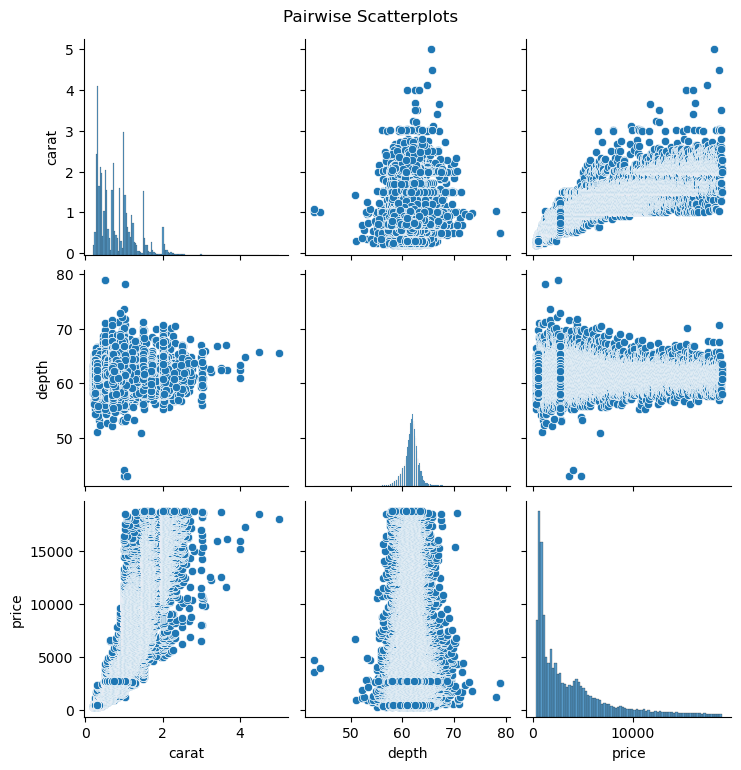

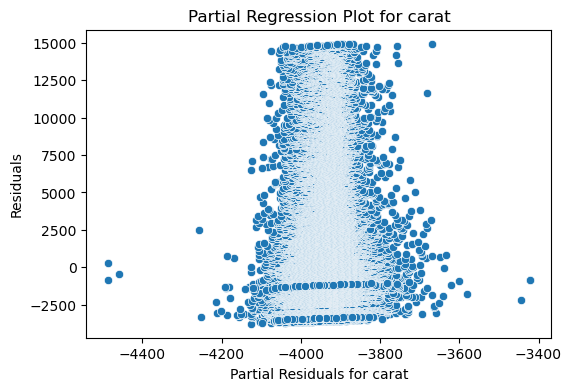

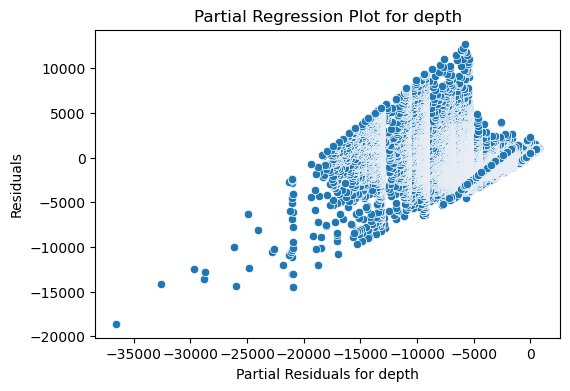


Explained Variance Ratio by PCA Components:
[0.64058632 0.33355049 0.02586319]

Conclusion:
1. Correlation Matrix: High correlation between features suggests multicollinearity.
2. VIF and Tolerance: VIF > 5 or Tolerance < 0.2 indicates multicollinearity.
3. Eigenvalues and Condition Index: Small eigenvalues and high condition index (>15) suggest multicollinearity.
4. Pairwise Scatterplots: Visual inspection of relationships between features.
5. Partial Regression Plots: Visualize the relationship between each feature and the target, controlling for other features.
6. PCA: A small number of components explaining a large proportion of variance indicates multicollinearity.


In [17]:
# Step 1: Correlation Matrix
corr_matrix = df_diamonds[['carat', 'depth', 'price']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

# Step 2: Compute VIF
X = df_diamonds[['carat', 'depth', 'price']]
X_scaled = StandardScaler().fit_transform(X)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print("VIF Data:")
print(vif_data)

# Step 3: Compute Tolerance
vif_data["Tolerance"] = 1 / vif_data["VIF"]
print("\nTolerance Data:")
print(vif_data)

# Step 4: Eigenvalues and Condition Index
correlation_matrix = X.corr()
eigenvalues, eigenvectors = np.linalg.eig(correlation_matrix)
condition_index = np.sqrt(eigenvalues.max() / eigenvalues)
print("\nEigenvalues:")
print(eigenvalues)
print("\nCondition Index:")
print(condition_index)

# Step 5: Pairwise Scatterplots
sns.pairplot(df_diamonds[['carat', 'depth', 'price']])
plt.suptitle("Pairwise Scatterplots", y=1.02)
plt.show()

# Step 6: Partial Regression Plots (using statsmodels)
import statsmodels.api as sm

for feature in ['carat', 'depth']:
    X_temp = df_diamonds[['carat', 'depth']].drop(feature, axis=1)
    X_temp = sm.add_constant(X_temp)
    y = df_diamonds['price']
    model = sm.OLS(y, X_temp).fit()
    residuals = model.resid
    partial_residuals = df_diamonds[feature] - model.predict(X_temp)
    
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=partial_residuals, y=residuals)
    plt.title(f"Partial Regression Plot for {feature}")
    plt.xlabel(f"Partial Residuals for {feature}")
    plt.ylabel("Residuals")
    plt.show()

# Step 7: Principal Component Analysis (PCA)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
print("\nExplained Variance Ratio by PCA Components:")
print(explained_variance_ratio)

print("\nConclusion:")
print("1. Correlation Matrix: High correlation between features suggests multicollinearity.")
print("2. VIF and Tolerance: VIF > 5 or Tolerance < 0.2 indicates multicollinearity.")
print("3. Eigenvalues and Condition Index: Small eigenvalues and high condition index (>15) suggest multicollinearity.")
print("4. Pairwise Scatterplots: Visual inspection of relationships between features.")
print("5. Partial Regression Plots: Visualize the relationship between each feature and the target, controlling for other features.")
print("6. PCA: A small number of components explaining a large proportion of variance indicates multicollinearity.")


## 3. Feature Selection

Feature selection is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. It is a critical step in the machine learning pipeline because it:
- **improves model performance** by removing irrelevant or redundant features, allowing the model to focus on the most important predictors;
- **reduces overfitting** by simplifying the model by reducing noise from unnecessary features;
- **enhances interpretability**, as fewer features make it easier to understand and explain the model;
- **reduces computational cost**, as fewer features mean faster training and inference times.

We can apply a variety of techniques in order to achieve this task. These techniques can be grouped into 2 main categories:

1. **Filter methods:** These techniques select features based on statistical measures independently of the model, and they are computationally efficient. Usually applied as a preprocessing step before applying more complex methods and when working with high-dimensional data. Common techniques include:
   1. **Correlation Coefficient:** Measures linear relationships between features and the target;
   2. **Chi-Square Test:** Measures the dependence between categorical features and the target;
   3. **Mutual Information:** Measures the dependency between features and the target;
   4. **Variance Threshold:** Removes features with low variance (e.g., constant features).
2. **Wrapper methods:** Wrapper methods evaluate subsets of features by training and evaluating a model on each subset. While it considers feature interactions and often results in better-performing models, they can be computationally expensive, as they require training models. They are use when computational resources are sufficient, and feature interactions are important. Some methods include:
   1. **Forward selection:** Starts with no features and iteratively adds the best-performing feature;
   2. **Backward Elimination:** Starts with all features and iteratively removes the least important feature;
   3. **Recursive Feature Elimination (RFE):** Recursively removes the least important features based on model weights (e.g., coefficients in linear models).

Present in models that support built-in feature selection, embedded methods perform feature selection as part of the final model's training process. They combine the benefits of filter and wrapper methods and are efficient as a bonus. These models include:
   1. **Lasso Regression (L1 Regularization)**
   2. **Ridge Regression (L2 Regularization)**
   3. **Tree-Based Methods**

Below we can see a feature selection of the diamonds dataset, applying techniques of the 2 main categories previously listed:

In [29]:
# Preprocessing
# Encode categorical variables
categorical_cols = ['cut', 'color', 'clarity']
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cols = encoder.fit_transform(df_diamonds[categorical_cols])
encoded_cols_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

# Combine encoded categorical features with numerical features
numerical_cols = ['carat', 'depth', 'table', 'x', 'y', 'z']
X = pd.concat([df_diamonds[numerical_cols], encoded_cols_df], axis=1)
y = df_diamonds['price']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Filter Method: SelectKBest with Mutual Information
selector = SelectKBest(mutual_info_regression, k=10)
X_filtered = selector.fit_transform(X_train, y_train)
selected_features_filter = X.columns[selector.get_support()]
print("Selected Features (Filter Method):", selected_features_filter)

# Wrapper Method: Recursive Feature Elimination (RFE)
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)
X_rfe = rfe.fit_transform(X_train, y_train)
selected_features_wrapper = X.columns[rfe.support_]
print("Selected Features (Wrapper Method):", selected_features_wrapper)

print("TO VALIDATE WE NEED TO TRAIN MODELS ON THE FEATURES SELECTED USING THE METHODS AND COMPARE EVALUATION METRICS LIKE R2 AND MSE.")

Selected Features (Filter Method): Index(['carat', 'x', 'y', 'z', 'color_E', 'color_F', 'color_G', 'clarity_SI1',
       'clarity_SI2', 'clarity_VS2'],
      dtype='object')
Selected Features (Wrapper Method): Index(['carat', 'x', 'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2',
       'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')
TO VALIDATE WE NEED TO TRAIN MODELS ON THE FEATURES SELECTED USING THE METHODS AND COMPARE EVALUATION METRICS LIKE R2 AND MSE.


## 4. Extra Resources

For further reading:
- [BuiltIn article](https://builtin.com/articles/feature-engineering)
- [Feature Engineering and Selection Book](http://www.feat.engineering/)
- [Scikit-learn: Feature Engineering](https://scikit-learn.org/stable/modules/feature_selection.html)
- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [Seaborn Visualization Guide](https://seaborn.pydata.org/)